# Class Discussion Data
The code below will build the data set from the handout today and plot the information in various forms to enable us to move quickly during the class meeting. We are beginning to use data sets that are too large to type in during a class example and this *Python* notebook will demonstrate loading data from text files.

## The Goal

The goal of the class exercise is to construct and interpret yoiur first Hammett plot. Ultimately we will come to the conclusion that the Hammett parameter, $\sigma$ is really just the $\Delta pK_a$ for the corresponding benzoic acids. The change in the $pK_a$ value in benzoic acid is what is being used as the score for electronoc effects for all the rest of chemistry. Do you agree?

## An Initial Plot

Hammett related the $K_a$ value of benzoic acid to the rate of hydrolysis of benzoate esters. The benzoate is not the leaving group in the rds and it is not an acid or a base. So, this is not a Brønsted plot. We are not relating the equilibrium for acid dissociation of benzoic acid to the rate of the benzoic acid group leaving, we are relating acid equilibrium to the rate of hydroxide attack on an ester. This is a different reaction. Bronsted plots relate apples to apples, Hammett expores how apples relate to oranges and the results are very informative.

So does the effect of a substituent on the benzoic acid $K_a$ value relate directly to the effect of that same substituent on the rate of ester hydrolysis? Let us plot the rate constant, $k_{OH^-}$ against the $K_a$ value. The text and code blocks below will take us through the process.



## Setup

The code below imports modules, below declares functions and sets up variables. Run it and then move on.

In [14]:
####################################################
### Import Libraries and set up global variables ###
####################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress

############################
### Set global variables ###
############################

local = False

if local == True:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_14/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_14/images/"

    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "/Users/blink/GitHub/4410PythonNotebooks/Class_14/data"
    image_path = "/Users/blink/GitHub/4410PythonNotebooks/Class_14/images/"
    
    github_data_location = "/Users/blink/GitHub/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/GitHub/LFER-QSAR/styles/"

#################################################################
### a function to fill in sigma for empty spaces in s+ and s- ###
#################################################################

def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

################################################################################
### a function to plot an x,y data set with options for line fits and labels ###
################################################################################


def plot_plot(x,y,names, 
              x_label = "x", 
              y_label = "y", 
              add_labels_flag = False, 
              line_fit_flag = False ):
    
    ##################################################
    ### Setup a figure and choose a stylesheet     ###
    ##################################################

    plot_style_file = github_styles_location + "tufte.mplstyle"   #"S2_classic2.mplstyle"
    plt.style.use(plot_style_file)                                       # Set plot style

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   


    #########################################
    ### Plot the data and the line fit.   ###
    #########################################

    if line_fit_flag:     # Change flag to True to plot a linear line fit, False to do a scatter plot
        linfit = linregress(x,y)
        fity = linfit.slope * x + linfit.intercept
        ax.plot(x, fity, color='black', zorder=1, linewidth=0.7)
        ax.scatter(x,y, s=64, color="white", zorder=3)
        ax.scatter(x,y, s=16, color="black", zorder=3)
    else:         
    #    ax.plot(x, y, color='black', zorder=1, linewidth=0.7)
        ax.scatter(x,y, s=64, color="white", zorder=3)
        ax.scatter(x,y, s=16, color="black", zorder=3)


    ############################
    ### Set labels and scale ###
    ############################

    ax.set(
    #    title="Initial Rate Log-Log Plot",       
            ylabel=y_label, 
            xlabel=x_label,                
    #        xlim=[-.48,None],                  
    #        ylim=[-.48,None]
            )


    ############################
    ### Print labels on plot ###
    ############################

    if add_labels_flag:      # Change to True to add annotations to the plot 
        #names = list(df.index)
        for name,x1,y1 in zip(names,x,y):
            plt.annotate(name,             # this is the text
                        (x1,y1),          # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-20),  # distance from text to points (x,y)
                        ha='left')      # horizontal alignment can be left, right or center


    #############################
    ### Output the final plot ###
    #############################

    fig.savefig("plot.pdf")   # use this to save the figure in PDF format
    plt.show()                 # output the combined plot plots


    #####################################
    ### Print the line fit parameters ###
    #####################################

    if line_fit_flag:         # Change to True to print a linear line fit results
        print(f"slope = {linfit.slope:0.2f} +/- {linfit.stderr:0.3f}")
        print(f"intercept = {linfit.intercept:0.3f} +/- {linfit.intercept_stderr:0.3f}")
        print(f"RSQ = {(linfit.rvalue**2):0.3f}")

## Load Data
The data in the handout (tables 1 and 2) are brief enough to type in directly. But the other tables are much larger and will be read in from text files, when we get to them. For our first plot, I set up a list of lists and converted it to a dataframe object. Then I can use the dataframe object and manipulate it just like a spreadsheet.

First I will enter the **data from tables 1 \& 2** in the class handout. I will use the $pK_a$ values from table 1 and the corresponding rate data from table 2. I'm just going to enter them directly as a matrix right here in this notebook.

Note: You will see our first exmple of a *dataframe* structure below. The dataframe is provided as part of the *Pandas$ package. It is a data object that behaves similarly to a spreadsheet and provides tools for access the data as row and columns.

In [15]:
######################################
### Set Up Dataframe for Reactions ###
######################################

# substituent, pKa, ester rate hydrolysis (M-1 s-1)

data = [["p-NO2",   3.45,  32.9 ],
        ["p-CN",    3.56,  15.7 ],
        ["p-Cl",    4.00,  2.10 ],
        ["H",       4.20,  0.289],
        ["p-CH3",   4.37,  0.172],
        ["p-OCH3",  4.47,  0.143]]

df = pd.DataFrame(data, columns=["Substituent", "pKa", "rate"])
df = df.set_index("Substituent")

df["log_rate"] = np.log10(df["rate"])  # make a new column with log rate data

print(df)

              pKa    rate  log_rate
Substituent                        
p-NO2        3.45  32.900  1.517196
p-CN         3.56  15.700  1.195900
p-Cl         4.00   2.100  0.322219
H            4.20   0.289 -0.539102
p-CH3        4.37   0.172 -0.764472
p-OCH3       4.47   0.143 -0.844664


## Pick x and y-values and Plot the Data

We need x and y-values to plot. The code block below will take the two data series in the data set and assign them to the two axes opf the plot.

The code below will plot any x,y pair that is in memory when it is run.  Set the flags to "True" or "False" to add substituent names or a line fit. 

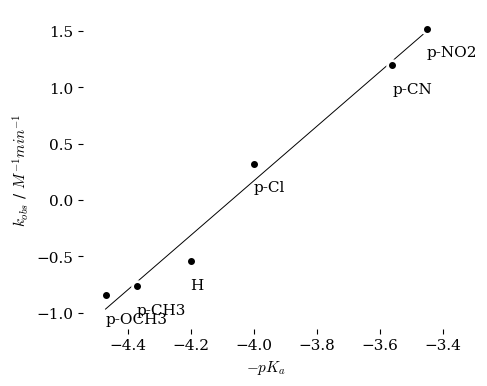

slope = 2.41 +/- 0.161
intercept = 9.819 +/- 0.647
RSQ = 0.983


In [16]:
#####################################################
### Get series of data to plot from the dataframe ###
#####################################################

x = -df["pKa"]                         # -pKa is the same as log Ka
y =  df["log_rate"]                    # log k vs log Ka is a log-log plot

names = list(df.index)                 # list of substituent names 
x_label = r"$-pK_a$"                   # labels for plot
y_label = r"$k_{obs}$ / $M^{-1} min^{-1}$"

#####################################################
### Call the plot_plot function
#####################################################

plot_plot(x, y, 
          names, x_label, y_label, 
          add_labels_flag = True, line_fit_flag = True)

## Use $\Delta pK_a$
The code in the blocks below adds columns to the dataframe and selects the x,y pairs to highlight various plots. Run one of the blocks below and then run the plotting block above to plot a give x,y data set.

              pKa    rate  log_rate  diff
Substituent                              
p-NO2        3.45  32.900  1.517196  0.75
p-CN         3.56  15.700  1.195900  0.64
p-Cl         4.00   2.100  0.322219  0.20
H            4.20   0.289 -0.539102  0.00
p-CH3        4.37   0.172 -0.764472 -0.17
p-OCH3       4.47   0.143 -0.844664 -0.27


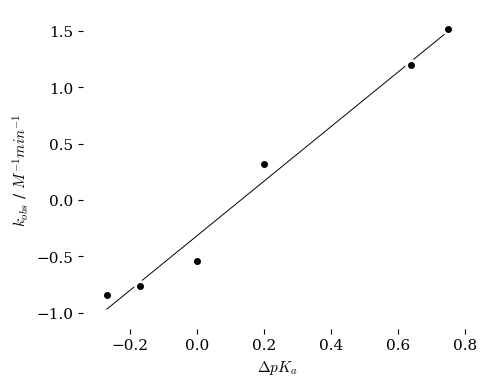

slope = 2.41 +/- 0.161
intercept = -0.315 +/- 0.069
RSQ = 0.983


In [17]:
df["diff"] = df["pKa"]["H"] - df["pKa"] # difference between pK_a for R=H and R=X

print(df)

x = df["diff"]
y = df["log_rate"]

names = list(df.index)                 # list of substituent names 
x_label = r"$\Delta pK_a$"
y_label = r"$k_{obs}$ / $M^{-1} min^{-1}$"

plot_plot(x,y, names, x_label, y_label, add_labels_flag = False, line_fit_flag = True)

## Load and process Hammett parameters
the code below loads the Hammett data from `LFER_HanschLeoTaft.csv` and processes it to remove the fields that we do not need (it is a large data set). I stores the dataframe as `df2`.



In [18]:

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################

filename = "LFER_HanschLeoTaft.csv"
#filename = "LFER_Williams.csv"

data = pd.read_csv(github_data_location + filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 

########################################################
### Fill across sigma values and select substituents ###
########################################################

data = fill_sigma(data)        

rowlist = ["m-Br", "p-Br", "m-CH3", "p-CH3", 
           "m-Cl", "p-Cl", "p-CN", "m-COCH3", 
           "p-COCH3", "m-F", "p-F", "H",
           "m-NO2",  "p-NO2", "m-OCH3", "p-OCH3"]
df2 = data.loc[rowlist]          # select rows that match these substituents
df2 = df2[["sigma"]]             # select column that matches this label

#### Remove unneeded columns
#to_be_dropped = ["TABLE V", "TABLE I", "s_minus", "s_plus", 
#                 "sigma_I", "sigma_n", "sigma_star", "F", "R", "R+", "R-"]
#df2.drop(labels = to_be_dropped,
#        axis = "columns",
#        inplace = True)

df2.sort_values(by=['sigma'], inplace=True)
print(df2)

             sigma
Substituent       
p-OCH3       -0.27
p-CH3        -0.17
m-CH3        -0.07
H             0.00
p-F           0.06
m-OCH3        0.12
p-Br          0.23
p-Cl          0.23
m-F           0.34
m-Cl          0.37
m-COCH3       0.38
m-Br          0.39
p-COCH3       0.50
p-CN          0.66
m-NO2         0.71
p-NO2         0.78


## Plot Using Hammett $\sigma$ Values from the Data Table
Include published $\sigma$ values for substituents. Plot $\log{rate}$ vs. $\sigma$. 

              pKa    rate  log_rate  diff  sigma
Substituent                                     
p-NO2        3.45  32.900  1.517196  0.75   0.78
p-CN         3.56  15.700  1.195900  0.64   0.66
p-Cl         4.00   2.100  0.322219  0.20   0.23
H            4.20   0.289 -0.539102  0.00   0.00
p-CH3        4.37   0.172 -0.764472 -0.17  -0.17
p-OCH3       4.47   0.143 -0.844664 -0.27  -0.27


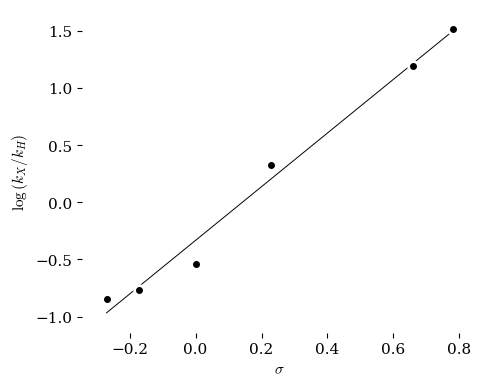

slope = 2.35 +/- 0.138
intercept = -0.334 +/- 0.062
RSQ = 0.986


In [19]:
s = "sigma"
#s = "s_plus"
#s = "s_minus"

df["sigma"] = df2[s]
print(df)

x = df["sigma"]
y = df["log_rate"] 

x_label = r"$\sigma$"
y_label = r"$\log{\left({k_{X}}/{k_{H}}\right)}$"
#y_label = r"$\sigma^+$"
#y_label = r"$\sigma^-$"

plot_plot(x,y, names, x_label, y_label, add_labels_flag = False, line_fit_flag = True)